# An Increase in Carbohydrate Consumption is Correlated with a Decrease in Happiness

## Overview

The relationship between dietary choice and happiness is one that is not well characterized. Here we sought to use descriptive and exploratory data analysis to World Happiness Report and United Nations Diet datasets in order to understand how the dietary composition broken down by food groups can affect one's happiness level. Through linear regression models generated from data on 128 countries, we determined that there is a negative correlation between percent calorie consumption from carbohydrates and happiness; that is, as one's carbohydrate consumption increases, the more likely that the individual has a lower happiness index. And while there is a positive association between protein consumption and happiness index, multivariate regression suggests that protein consumption is likely confounded by wealth level, as measured by GDP. We hope that our results can shed light on how dietary choice may affect happiness and inspire further medical scrutiny on how diet may affect happiness.

## Names

- Mason Pak
- James Wang
- Helen Chang

## Research Question

Does a relationship exist between a country's average consumption of various food groups and its happiness index as scored by the World Happiness Report (1)? In this context, 'average consumption' is measured by percentage of total consumed calories that is composed of some food group. The food groups referenced in this analysis are a variation of those defined by the MyPlate initiative of the U.S. Department of Agriculture (2): Fruits, Vegetables, Carbohydrates, Alcohol, Protein, and Sugars.

## Background Research

### Why is this project of interest to your group?

Every year, the World Happiness Report calculates a happiness score for every country determined by surveys of its citizens, GDP per capita, life expectancy, perceptions of corruption, social support, generosity, freedom of individuals to make choices about their lives, and a plethora of other features (3). The 2020 report recognizes that health, which is often a measure of wellbeing, does have a positive correlation with a country's happiness index. 

However, the report does not draw any conclusions about possible correlations between dietary habits and happiness, even though studies have consistently shown that diet can have major impacts on both mental and physical health (4). This project presents a unique opportunity to possibly draw new insights about the impact of different types of food.

### What background information led to your hypothesis?

As mentioned in the previous subsection, multiple external studies support the notion that diet can heavily affect people's health and wellbeing. For example, a balanced diet has consistently been correlated with better quality sleep, higher levels of concentration, lowered risks of cardiovascular and chronic diseases, improved mental health, and more (4). With the massive role that diet plays in the health of individuals and given the recognized correlation between health and happiness (3), we believe it is likely that there exists a relationship between dietary habits and happiness levels. 

According to Medical News Today, a newsletter whose articles are peer-reviewed by medical professionals, the highest proportion of available nutrients and superfoods lies in fruits and vegetables (6). Thus, we predict that countries with the highest diet makeup by percentage of fruits and vegetables will generally score higher on the measure of happiness.

### Why is this important?

Drawing more detailed conclusions about the relationship between diet and happiness could lead to a shift in people's shopping and eating habits as if any correlations can be established beteween happiness and specific food groups, there will be increased urgency to purchase and consume foods of that category. This also has the potential to further encourage efforts in resolving issues like food deserts, where lower income areas typically have extreme difficulty obtaining fresh produce if a relationship can be established between fruits or vegetables and happiness. While the importance of healthy food has already been demonstrated for psychological and bodily health, this analysis can explore whether diet has sway over a different, more abstract aspect of our lives: happiness.

## Hypothesis

Countries whose average diets are composed of a higher percentage of fruits and vegetables tend to receive higher happiness indices than the countries with lower consumption rates of those food categories.

## Dataset(s)

#### Dataset 1: COVID-19 Healthy Diet Dataset
**Link** - https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset <br>
**Number of Observations** - 171 <br>
**Description** - Dataset 1 records COVID spread and recovery data as well as assorted dietary and general statistics of 171 countries in 2019, with data sourced from the Food and Agriculture Organization of the United Nations website. For the purposes of this study, we will focus on data detailing the average percentages of energy intake by kcal from different food groups as well as GDP (as a measure of wealth, used to analysis on confounding factors). We will specifically be using the Food_Supply_kcal_Data.csv for our analysis.<br>

#### Dataset 2: World Happiness Report
**Link** - https://www.kaggle.com/mathurinache/world-happiness-report <br>
**Number of Observations** - 154 <br>
**Description** - Dataset 2 records the happiness indices of 154 countries from 2015 to 2020, as collected by the Gallup World Poll. Samples of nationally representative individuals from each country were given life evaluation questions (the Cantril ladder), and happiness scores were computed based on the six factors economic production, social support, life expectancy, freedom, absence of corruption, and generosity. We will specifically be using the 2020.csv for our analysis.<br>

We will do an inner merge on both datasets using country as the index.  

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
food_df = pd.read_csv('diet_to_covid_data/Food_Supply_kcal_Data.csv')
happy_df = pd.read_csv('world_happiness/2020.csv')

## Data Cleaning

The first dataset we use (COVID-19 Healthy Diet Dataset) had data relating to the death and recovery rate due to COVID-19 among each country's citizens. However, as our analysis is completely unrelated to COVID-19, we removed all of that peripheral data. It also had separate categories for different kinds of proteins (Meat, Fish/Seafood, Eggs, and Treenuts) and carbohydrates (Starchy Roots and Grains). As our research was more concerned with the general food groups, we combined those subcategories into the selected groups as stated in the Research Question section. There were also multiple categories that overlapped in content (e.g. Oils and Vegetable Products), as such we removed all duplicate categories and any food groups that were outside of the scope of our question (e.g. Fats).

The second dataset (World Happiness Report) has data on not only the individual happiness of each country, but also has related variables used to calculate those scores (e.g. GDP). We removed most of the determining factors used for their calculation as we were more interested in a general correlation between diet and the overall happiness score. However, we did ultimately choose to keep GDP within the dataframe as we wanted to explore whether a country's financial state was a confounding factor for happiness and diet in our analysis.

Our final check to ensure that the data was usable was to make sure there were no null values or duplicate countries in either dataset before merging the two dataframes using country as index. This merge automatically removes any observations that are not already in both datasets.

In [3]:
#remove columns that pertain to COVID-19
food_df = food_df.drop(['Confirmed','Deaths','Recovered','Active'], axis=1)

#combining all protein types into one column
food_df['Protein'] = food_df['Meat'] + food_df['Fish, Seafood'] + food_df['Eggs'] + food_df['Treenuts']

#combining all carbohydrates
food_df['Carbohydrates'] = food_df['Starchy Roots'] + food_df['Cereals - Excluding Beer']

#removing duplicate and out of scope columns
food_df = food_df[['Country','Protein','Alcoholic Beverages','Carbohydrates',
                   'Fruits - Excluding Wine','Sugar & Sweeteners', 'Vegetables']]

In [4]:
#rename columns
food_df = food_df.rename(columns={'Alcoholic Beverages' : 'Alcohol',
                                  'Fruits - Excluding Wine' : 'Fruits',
                                  'Sugar & Sweeteners' : 'Sugars'})

In [5]:
#check for nulls 
food_df.isna().any()

Country          False
Protein          False
Alcohol          False
Carbohydrates    False
Fruits           False
Sugars           False
Vegetables       False
dtype: bool

In [6]:
#check for duplicates in the Country column
food_df['Country'].duplicated().any()

False

In [7]:
#remove columns that are out of scope
happy_df = happy_df[['Country name','Regional indicator','Ladder score',
                     'Standard error of ladder score', 'Logged GDP per capita']]

In [8]:
#rename columns
happy_df = happy_df.rename(columns={'Country name' : 'Country',
                                   'Regional indicator' : 'Region',
                                   'Ladder score' : 'Happiness_Index',
                                   'Standard error of ladder score' : 'Standard Error of HI',
                                   'Logged GDP per capita' : 'GDP'})

In [9]:
#check for nulls 
happy_df.isna().any()

Country                 False
Region                  False
Happiness_Index         False
Standard Error of HI    False
GDP                     False
dtype: bool

In [10]:
#check for duplicates in the Country column
happy_df['Country'].duplicated().any()

False

In [11]:
#merging
df = food_df.merge(happy_df, on='Country')

In [12]:
df

,Country,Protein,Alcohol,Carbohydrates,Fruits,Sugars,Vegetables,Region,Happiness_Index,Standard Error of HI,GDP
0,Afghanistan,1.4758,0.0000,37.4438,1.4757,2.2261,0.7504,South Asia,2.5669,0.031311,7.462861
1,Albania,5.2222,0.9120,17.4758,3.8982,3.4422,2.7508,Central and Eastern Europe,4.8827,0.056116,9.417931
2,Algeria,2.0159,0.0896,26.9374,3.1805,3.9869,2.0457,Middle East and North Africa,5.0051,0.044236,9.537965
3,Argentina,10.5571,1.4354,18.1972,1.4663,7.0536,0.8643,Latin America and Caribbean,5.9747,0.053442,9.810955
4,Armenia,5.4418,0.2274,20.5166,2.5341,5.2956,3.2164,Commonwealth of Independent States,4.6768,0.058595,9.100476
...,...,...,...,...,...,...,...,...,...,...,...
123,Uzbekistan,4.2197,0.6785,26.4438,2.2174,1.7045,3.2269,Commonwealth of Independent States,6.2576,0.054228,8.740372
124,Vietnam,9.5165,0.7150,27.6983,1.8046,2.0940,1.9578,Southeast Asia,5.3535,0.033801,8.809546
125,Yemen,2.3515,0.0000,32.3879,1.1879,7.0303,0.3636,Middle East and North Africa,3.5274,0.054158,7.759683
126,Zambia,2.2857,1.1925,35.6522,0.2236,2.5590,0.4472,Sub-Saharan Africa,3.7594,0.060677,8.224720


## Data Analysis & Results

### Descriptive Analysis

First, calculations of average values and standard deviation for the happiness index and each food category alongside their univariate histograms:

#### Happiness Index

In [13]:
# mean and std deviation of happiness index
print("Average of happiness index: %4.3f" % (df['Happiness_Index'].mean()))
print("Standard Deviation of happiness index: %4.3f" % (df['Happiness_Index'].std()))

Average of happiness index: 5.522
Standard Deviation of happiness index: 1.122


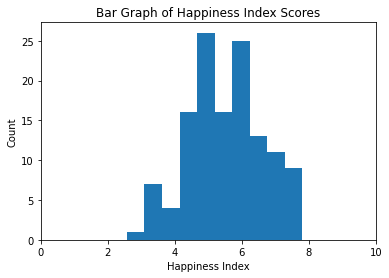

In [14]:
hi_hist = df['Happiness_Index'].hist(bins=10, grid=False)
hi_hist.set_xlim(0,10)
hi_hist.set_xlabel("Happiness Index")
hi_hist.set_ylabel("Count")
hi_hist.set_title("Bar Graph of Happiness Index Scores")
hi_hist

The distribution of protein consumption appears to be unimodal and fairly normally distributed with all values landing between 2% and 8%. Visually, the mode and the average appear to occur at roughly the same value of 5.2.

#### Protein Consumption

In [15]:
# mean and std deviation of protein consumption
print("Mean of percent protein in diet: %4.3f" % (df['Protein'].mean()))
print("Standard Deviation of percent protein in diet: %4.3f" % (df['Protein'].std()))

Mean of percent protein in diet: 5.082
Standard Deviation of percent protein in diet: 2.687


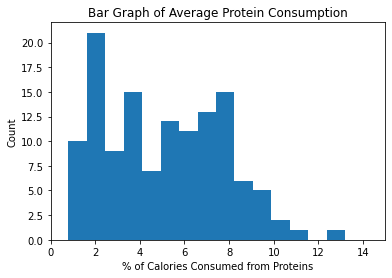

In [16]:
prot_hist = df['Protein'].hist(bins=15, grid=False)
prot_hist.set_xlim(0,15)
prot_hist.set_xlabel("% of Calories Consumed from Proteins")
prot_hist.set_ylabel("Count")
prot_hist.set_title("Bar Graph of Average Protein Consumption")
prot_hist

The distribution of protein consumption appears to be bimodal and slightly skewed right with all values landing below 14%. Visually, the two peaks appear to be at around 2% and 7%.

#### Alcohol Consumption

In [17]:
# mean and std deviation of alcohol consumption
print("Mean of percent alcohol in diet: %4.3f" % (df['Alcohol'].mean()))
print("Standard Deviation of percent alcohol in diet: %4.3f" % (df['Alcohol'].std()))

Mean of percent alcohol in diet: 1.337
Standard Deviation of percent alcohol in diet: 1.100


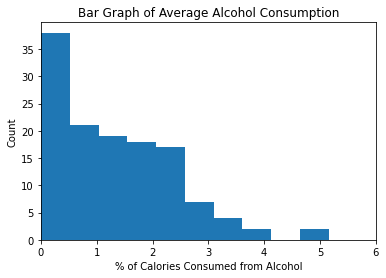

In [18]:
alc_hist = df['Alcohol'].hist(bins=10, grid=False)
alc_hist.set_xlim(0,6)
alc_hist.set_xlabel("% of Calories Consumed from Alcohol")
alc_hist.set_ylabel("Count")
alc_hist.set_title("Bar Graph of Average Alcohol Consumption")
alc_hist

The distribution of alcohol consumption appears to be unimodal and strongly skewed right with all values being below 6%. Visually, the mode appears to be around 1%.

#### Carbohydrate Consumption

In [19]:
# mean and std deviation of carbohydrate consumption
print("Mean of percent carbohydrates in diet: %4.3f" % (df['Carbohydrates'].mean()))
print("Standard Deviation of percent carbohydrates in diet: %4.3f" % (df['Carbohydrates'].std()))

Mean of percent carbohydrates in diet: 23.768
Standard Deviation of percent carbohydrates in diet: 7.130


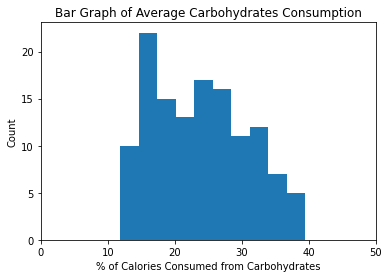

In [20]:
carb_hist = df['Carbohydrates'].hist(bins=10, grid=False)
carb_hist.set_xlim(0,50)
carb_hist.set_xlabel("% of Calories Consumed from Carbohydrates")
carb_hist.set_ylabel("Count")
carb_hist.set_title("Bar Graph of Average Carbohydrates Consumption")
carb_hist

The distribution of carbohydrate consumption appears to be unimodal and slightly skewed right with all values being between 10% and 40% across all observations. Visually, the mode appears to be roughly the same as the average at around 24%.

#### Fruit Consumption

In [21]:
# mean and std deviation of fruit consumption
print("Mean of percent fruits in diet: %4.3f" % (df['Fruits'].mean()))
print("Standard Deviation of percent fruits in diet: %4.3f" % (df['Fruits'].std()))

Mean of percent fruits in diet: 1.846
Standard Deviation of percent fruits in diet: 1.298


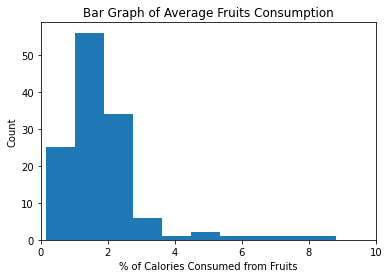

In [22]:
fruit_hist = df['Fruits'].hist(bins=10, grid=False)
fruit_hist.set_xlim(0,10)
fruit_hist.set_xlabel("% of Calories Consumed from Fruits")
fruit_hist.set_ylabel("Count")
fruit_hist.set_title("Bar Graph of Average Fruits Consumption")
fruit_hist

The distribution of fruit consumption appears to be unimodal and strongly skewed right with all values being under 10% across all observations. Based on the above figure, the mode appears to be at around 1.2%.

#### Vegetable Consumption

In [23]:
# mean and std deviation of vegetable consumption
print("Mean of percent vegetables in diet: %4.3f" % (df['Vegetables'].mean()))
print("Standard Deviation of percent vegetables in diet: %4.3f" % (df['Vegetables'].std()))

Mean of percent vegetables in diet: 1.089
Standard Deviation of percent vegetables in diet: 0.641


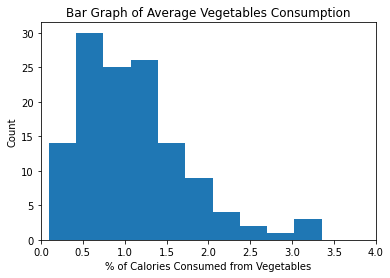

In [24]:
veg_hist = df['Vegetables'].hist(bins=10, grid=False)
veg_hist.set_xlim(0,4)
veg_hist.set_xlabel("% of Calories Consumed from Vegetables")
veg_hist.set_ylabel("Count")
veg_hist.set_title("Bar Graph of Average Vegetables Consumption")
veg_hist

The distribution of vegetable consumption appears to be unimodal and strongly skewed right with all values being under 4% across all observations. The mode appears to be around 0.75% based on the figure above.

#### Sugar Consumption

In [25]:
# mean and std deviation of vegetable consumption
print("Mean of percent sugar in diet: %4.3f" % (df['Sugars'].mean()))
print("Standard Deviation of percent sugar in diet: %4.3f" % (df['Sugars'].std()))

Mean of percent sugar in diet: 4.699
Standard Deviation of percent sugar in diet: 2.090


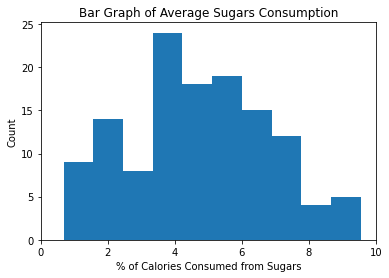

In [26]:
sugar_hist = df['Sugars'].hist(bins=10, grid=False)
sugar_hist.set_xlim(0,10)
sugar_hist.set_xlabel("% of Calories Consumed from Sugars")
sugar_hist.set_ylabel("Count")
sugar_hist.set_title("Bar Graph of Average Sugars Consumption")
sugar_hist

The distribution of sugar consumption appears to be unimodal and slightly skewed right with all values being under 10% across all observations. The average and the mode appear to line up at roughly 4.7%.

### Exploratory Data Analysis

We recognize that there may exist outliers when considering the univariate distributions noted in the Descriptive Analysis. Since each observation contains multiple data points, just because they are an outlier in a single category is not a valid reason to remove said observation.

Analyze each food category to determine whether a relationship exists between it and happiness index scores:

#### Protein to Happiness Index

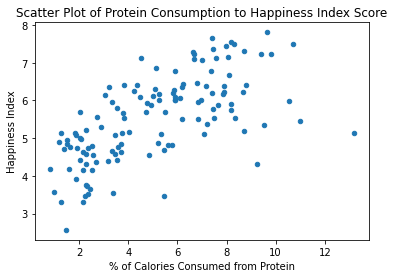

In [27]:
prot_scat = df.plot.scatter(x='Protein', y='Happiness_Index')
prot_scat.set_title("Scatter Plot of Protein Consumption to Happiness Index Score")
prot_scat.set_xlabel("% of Calories Consumed from Protein")
prot_scat.set_ylabel("Happiness Index")
prot_scat

There is a fairly strong positive association between a country's protein consumption and happiness score. The shape of the scatter plot appears as though there may be a logarithmic relationship between the two variables.

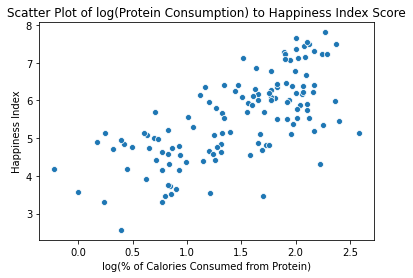

In [28]:
prot_log_scat = sns.scatterplot(x=np.log(df['Protein']), y=df['Happiness_Index'])
prot_log_scat.set_title("Scatter Plot of log(Protein Consumption) to Happiness Index Score")
prot_log_scat.set_ylabel("Happiness Index")
prot_log_scat.set_xlabel("log(% of Calories Consumed from Protein)")
prot_log_scat

There is a very strong positive, linear association between the logarithm of a country's protein consumption and its happiness score. 

#### Alcohol to Happiness Index

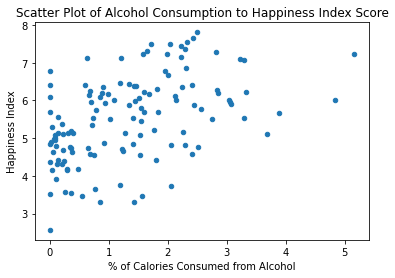

In [29]:
alc_scat = df.plot.scatter(x='Alcohol', y='Happiness_Index')
alc_scat.set_title("Scatter Plot of Alcohol Consumption to Happiness Index Score")
alc_scat.set_xlabel("% of Calories Consumed from Alcohol")
alc_scat.set_ylabel("Happiness Index")
alc_scat

There is a positive association between a country's alcohol consumption and happiness score. There is a linear shape to the scatter plot, but there is clustering of the data towards the lower end of the axes that could suggest a logarithmic relationship.

#### Carbohydrates to Happiness Index

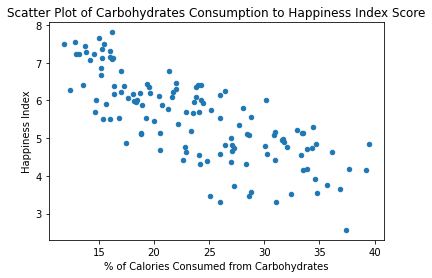

In [30]:
carb_scat = df.plot.scatter(x='Carbohydrates', y='Happiness_Index')
carb_scat.set_title("Scatter Plot of Carbohydrates Consumption to Happiness Index Score")
carb_scat.set_xlabel("% of Calories Consumed from Carbohydrates")
carb_scat.set_ylabel("Happiness Index")
carb_scat

There is an extremely strong negative association between a country's carbohydrate consumption and happiness score. The shape of the scatter plot appears as though there is a strong linear relationship between the two variables.

#### Fruit to Happiness Index

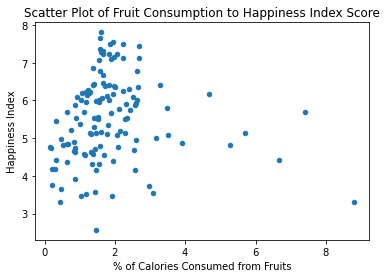

In [31]:
fruit_scat = df.plot.scatter(x='Fruits', y='Happiness_Index')
fruit_scat.set_title("Scatter Plot of Fruit Consumption to Happiness Index Score")
fruit_scat.set_xlabel("% of Calories Consumed from Fruits")
fruit_scat.set_ylabel("Happiness Index")
fruit_scat

There is a fairly strong positive association between a country's fruit consumption and happiness score. The shape of the scatter plot suggests the existence of some outliers.

#### Vegetable to Happiness Index

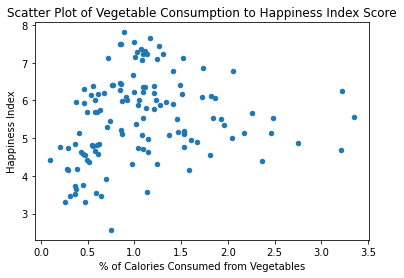

In [32]:
veg_scat = df.plot.scatter(x='Vegetables', y='Happiness_Index')
veg_scat.set_title("Scatter Plot of Vegetable Consumption to Happiness Index Score")
veg_scat.set_xlabel("% of Calories Consumed from Vegetables")
veg_scat.set_ylabel("Happiness Index")
veg_scat

There is a positive association between a country's vegetable consumption and happiness score. The shape of the scatter plot appears as though there may be a linear relationship between the two variables.

#### Sugar to Happiness Index

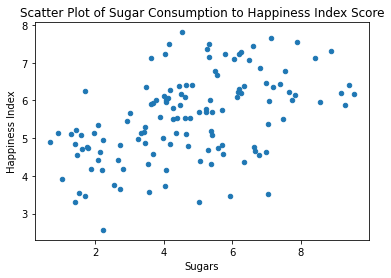

In [33]:
sugar_scat = df.plot.scatter(x='Sugars', y='Happiness_Index')
sugar_scat.set_title("Scatter Plot of Sugar Consumption to Happiness Index Score")
sugar_scat.set_ylabel("Happiness Index")
sugar_scat

There is a strong positive association between a country's sugar consumption and happiness score. The shape of the scatter plot appears as though there may be a linear relationship between the two variables.

### Analysis

#### Fitting Linear Regression Model to Protein

In [34]:
# protein: linear model
prot_lin_outcomes, prot_lin_predictors = patsy.dmatrices('Happiness_Index ~ Protein', df)
prot_lin_mod = sm.OLS(prot_lin_outcomes, prot_lin_predictors)
prot_lin_res = prot_lin_mod.fit()
prot_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     91.06
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.42e-16
Time:                        02:16:41   Log-Likelihood:                -161.09
No. Observations:                 128   AIC:                             326.2
Df Residuals:                     126   BIC:                             331.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1474      0.163     25.467      0.000       3.825       4.470
Protein        0.2706      0.028      9.543      0.000       0.214       0.327
==============================================================================
Omnibus:                        5.620   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.434
Skew:                          -0.504   Prob(JB):                       0.0661
Kurtosis:                       3.055   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# protein: logarithmic model
df['log_protein'] = np.log(df['Protein'])
prot_log_outcomes, prot_log_predictors = patsy.dmatrices('Happiness_Index ~ log_protein', df)
prot_log_mod = sm.OLS(prot_log_outcomes, prot_log_predictors)
prot_log_res = prot_log_mod.fit()
prot_log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     109.1
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           8.96e-19
Time:                        02:16:41   Log-Likelihood:                -155.99
No. Observations:                 128   AIC:                             316.0
Df Residuals:                     126   BIC:                             321.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7126      0.188     19.746      0.000       3.341       4.085
log_protein     1.2402      0.119     10.443      0.000       1.005       1.475
==============================================================================
Omnibus:                        3.965   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                3.887
Skew:                          -0.380   Prob(JB):                        0.143
Kurtosis:                       2.612   Cond. No.                         5.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model's R-squared value (0.420) between protein consumption and happiness index is slightly lower than the logarithmic value (0.464). Furthermore, from the Exploratory Data Analysis, the data is visually curved and as such, a linear model is not appropriate.

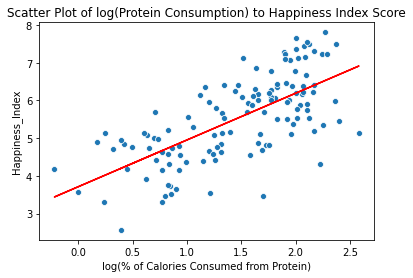

In [36]:
# graph the logarithmically scaled regression model for protein onto the scatter plot
prot_log_scat = sns.scatterplot(x=np.log(df['Protein']), y=df['Happiness_Index'])
prot_log_scat.set_title("Scatter Plot of log(Protein Consumption) to Happiness Index Score")
prot_log_scat.set_xlabel("log(% of Calories Consumed from Protein)")

x = np.log(df['Protein']).to_numpy()
m = prot_log_res.params[1]
b = prot_log_res.params[0]
prot_log_scat.plot(x, m * x + b, color="r")

#### Fitting Linear Regression Model to Alcohol

In [37]:
# alcohol: linear model
alc_lin_outcomes, alc_lin_predictors = patsy.dmatrices('Happiness_Index ~ Alcohol', df)
alc_lin_mod = sm.OLS(alc_lin_outcomes, alc_lin_predictors)
alc_lin_res = alc_lin_mod.fit()
alc_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     36.25
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.76e-08
Time:                        02:16:42   Log-Likelihood:                -179.71
No. Observations:                 128   AIC:                             363.4
Df Residuals:                     126   BIC:                             369.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8773      0.139     35.213      0.000       4.603       5.151
Alcohol        0.4825      0.080      6.021      0.000       0.324       0.641
==============================================================================
Omnibus:                        2.037   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.736
Skew:                          -0.152   Prob(JB):                        0.420
Kurtosis:                       2.517   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

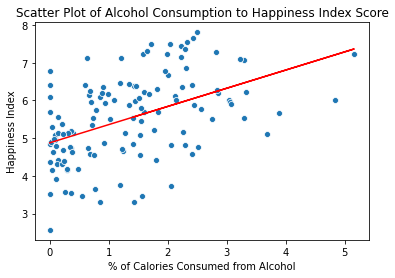

In [38]:
# graph the logarithmically scaled regression model for alcohol onto the scatter plot
alc_scat = sns.scatterplot(x=df['Alcohol'], y=df['Happiness_Index'])
alc_scat.set_title("Scatter Plot of Alcohol Consumption to Happiness Index Score")
alc_scat.set_xlabel("% of Calories Consumed from Alcohol")
alc_scat.set_ylabel("Happiness Index")


x = df['Alcohol']
m = alc_lin_res.params[1]
b = alc_lin_res.params[0]
alc_scat.plot(x, m * x + b, color="r")

There is significant clustering of values in the lower ranges of alcohol calorie consumption. Furthermore, the R-squared value is very low (0.223), indicating that a correlation between alcohol calorie consumption and happiness is unlikely.

#### Fitting Linear Regression Model to Carbohydrates

In [39]:
# carbohydrates: linear model
carbs_lin_outcomes, carbs_lin_predictors = patsy.dmatrices('Happiness_Index ~ Carbohydrates', df)
carbs_lin_mod = sm.OLS(carbs_lin_outcomes, carbs_lin_predictors)
carbs_lin_res = carbs_lin_mod.fit()
carbs_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     176.7
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           9.64e-26
Time:                        02:16:42   Log-Likelihood:                -139.80
No. Observations:                 128   AIC:                             283.6
Df Residuals:                     126   BIC:                             289.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.3812      0.224     37.342      0.000       7.937       8.825
Carbohydrates    -0.1203      0.009    -13.293      0.000      -0.138      -0.102
==============================================================================
Omnibus:                        6.765   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.647
Skew:                          -0.511   Prob(JB):                       0.0360
Kurtosis:                       2.552   Cond. No.                         86.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

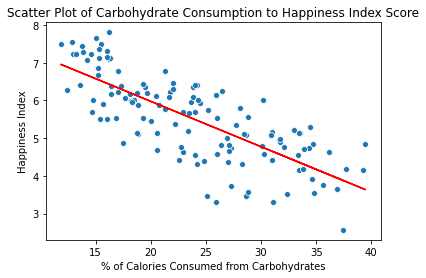

In [40]:
# graph the logarithmically scaled regression model for carbohydrate onto the scatter plot
carbs_scat = sns.scatterplot(x=df['Carbohydrates'], y=df['Happiness_Index'])
carbs_scat.set_title("Scatter Plot of Carbohydrate Consumption to Happiness Index Score")
carbs_scat.set_xlabel("% of Calories Consumed from Carbohydrates")
carbs_scat.set_ylabel("Happiness Index")


x = df['Carbohydrates']
m = carbs_lin_res.params[1]
b = carbs_lin_res.params[0]
carbs_scat.plot(x, m * x + b, color="r")

The R-squared value is very high at 0.584, indicating that 58.4% of the variance in happiness can be explained by calorie consumption from carbohydrates. There is a negative correlation between carbohydrate calorie consumption and happiness.

#### Fitting Linear Regression Model to Fruits

In [41]:
# Fruits: linear model
fruits_lin_outcomes, fruits_lin_predictors = patsy.dmatrices('Happiness_Index ~ Fruits', df)
fruits_lin_mod = sm.OLS(fruits_lin_outcomes, fruits_lin_predictors)
fruits_lin_res = fruits_lin_mod.fit()
fruits_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1445
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.704
Time:                        02:16:42   Log-Likelihood:                -195.82
No. Observations:                 128   AIC:                             395.6
Df Residuals:                     126   BIC:                             401.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4685      0.173     31.519      0.000       5.125       5.812
Fruits         0.0293      0.077      0.380      0.704      -0.123       0.182
==============================================================================
Omnibus:                        1.958   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.569
Skew:                          -0.098   Prob(JB):                        0.456
Kurtosis:                       2.495   Cond. No.                         4.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

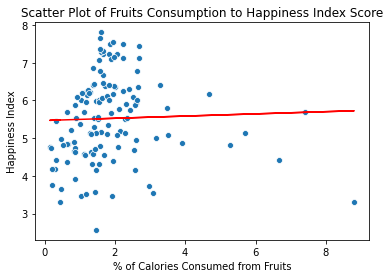

In [42]:
# graph the logarithmically scaled regression model for fruits onto the scatter plot
fruits_scat = sns.scatterplot(x=df['Fruits'], y=df['Happiness_Index'])
fruits_scat.set_title("Scatter Plot of Fruits Consumption to Happiness Index Score")
fruits_scat.set_xlabel("% of Calories Consumed from Fruits")
fruits_scat.set_ylabel("Happiness Index")


x = df['Fruits']
m = fruits_lin_res.params[1]
b = fruits_lin_res.params[0]
fruits_scat.plot(x, m * x + b, color="r")

The R-squared value is extremely low at 0.001. This suggests that there is no correlation between fruit calorie consumption and happiness.

#### Fitting Linear Regression Model to Vegetables

In [43]:
# Vegetables: linear model
veg_lin_outcomes, veg_lin_predictors = patsy.dmatrices('Happiness_Index ~ Vegetables', df)
veg_lin_mod = sm.OLS(veg_lin_outcomes, veg_lin_predictors)
veg_lin_res = veg_lin_mod.fit()
veg_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     4.935
Date:                Sun, 13 Dec 2020   Prob (F-statistic):             0.0281
Time:                        02:16:43   Log-Likelihood:                -193.44
No. Observations:                 128   AIC:                             390.9
Df Residuals:                     126   BIC:                             396.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1524      0.193     26.680      0.000       4.770       5.535
Vegetables     0.3399      0.153      2.221      0.028       0.037       0.643
==============================================================================
Omnibus:                        3.740   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.221
Skew:                           0.045   Prob(JB):                        0.329
Kurtosis:                       2.361   Cond. No.                         3.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

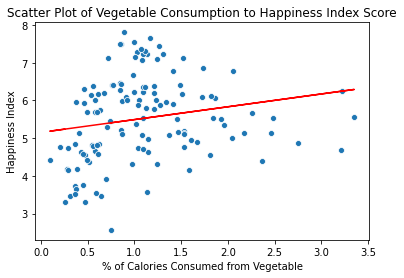

In [44]:
# graph the logarithmically scaled regression model for fruits onto the scatter plot
veg_scat = sns.scatterplot(x=df['Vegetables'], y=df['Happiness_Index'])
veg_scat.set_title("Scatter Plot of Vegetable Consumption to Happiness Index Score")
veg_scat.set_xlabel("% of Calories Consumed from Vegetable")
veg_scat.set_ylabel("Happiness Index")


x = df['Vegetables']
m = veg_lin_res.params[1]
b = veg_lin_res.params[0]
veg_scat.plot(x, m * x + b, color="r")

The R-squared value is very low at 0.038. This suggests that there is no correlation between fruit calorie consumption and happiness.

#### Fitting Linear Regression Model to Sugars

In [45]:
# Sugars: linear model
sug_lin_outcomes, sug_lin_predictors = patsy.dmatrices('Happiness_Index ~ Sugars', df)
sug_lin_mod = sm.OLS(sug_lin_outcomes, sug_lin_predictors)
sug_lin_res = sug_lin_mod.fit()
sug_lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     38.66
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           6.81e-09
Time:                        02:16:43   Log-Likelihood:                -178.77
No. Observations:                 128   AIC:                             361.5
Df Residuals:                     126   BIC:                             367.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2996      0.215     19.988      0.000       3.874       4.725
Sugars         0.2603      0.042      6.218      0.000       0.177       0.343
==============================================================================
Omnibus:                        0.858   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.651   Jarque-Bera (JB):                0.833
Skew:                          -0.192   Prob(JB):                        0.659
Kurtosis:                       2.905   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

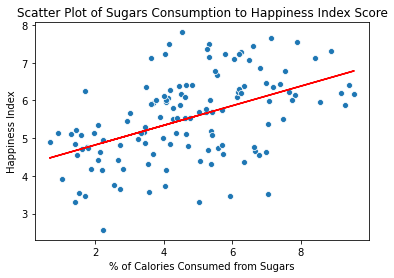

In [46]:
# graph the logarithmically scaled regression model for fruits onto the scatter plot
sug_scat = sns.scatterplot(x=df['Sugars'], y=df['Happiness_Index'])
sug_scat.set_title("Scatter Plot of Sugars Consumption to Happiness Index Score")
sug_scat.set_xlabel("% of Calories Consumed from Sugars")
sug_scat.set_ylabel("Happiness Index")


x = df['Sugars']
m = sug_lin_res.params[1]
b = sug_lin_res.params[0]
sug_scat.plot(x, m * x + b, color="r")

The R-squared value is 0.235, indicating that 23.5% of the variance in happiness can be explained by calorie consumption from sugars. This suggests that there is a weak positive correlation between sugar calorie consumption and happiness.

#### Multivariate Linear Regression Model

Here we create a multivariate regression using the most highly correlated sources of calorie consumption to happiness. This includes calorie sources of log(protein), carbohydrates, and sugars. 

In [47]:
# log(Protein), Carbohydrate, Sugar: multiple linear model
combo_outcomes, combo_predictors = patsy.dmatrices('Happiness_Index ~ log_protein + Carbohydrates + Sugars + Alcohol',
                                                   df)
combo_mod = sm.OLS(combo_outcomes, combo_predictors)
combo_res = combo_mod.fit()
combo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     47.13
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           5.77e-24
Time:                        02:16:44   Log-Likelihood:                -136.42
No. Observations:                 128   AIC:                             282.8
Df Residuals:                     123   BIC:                             297.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.6930      0.708      9.450      0.000       5.291       8.095
log_protein       0.3722      0.168      2.217      0.028       0.040       0.705
Carbohydrates    -0.0834      0.017     -4.821      0.000      -0.118      -0.049
Sugars            0.0447      0.038      1.176      0.242      -0.031       0.120
Alcohol           0.0445      0.074      0.604      0.547      -0.101       0.190
==============================================================================
Omnibus:                        9.404   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                5.875
Skew:                          -0.366   Prob(JB):                       0.0530
Kurtosis:                       2.249   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using an alpha value of 0.05, it appears that calorie consumption from log(Protein) (p-value = 0.028) and carbohydrates (p-value < 0.001).

#### Multivariate Linear Regression Model with GDP as a Confounder

We will now conduct multiple linear regression with the significant predictor variables calorie consumption from protein and carbohydrates as well as the potential confounding variable GDP to determine if GDP more significantly explains happiness than protein and carbohydrate consumption.

In [48]:
# Confo: linear model
conf1_outcomes, conf1_predictors = patsy.dmatrices('Happiness_Index ~ log_protein + Carbohydrates + GDP', df)
conf1_mod = sm.OLS(conf1_outcomes, conf1_predictors)
conf1_res = conf1_mod.fit()
conf1_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness_Index   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     78.51
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.58e-28
Time:                        02:16:44   Log-Likelihood:                -127.77
No. Observations:                 128   AIC:                             263.5
Df Residuals:                     124   BIC:                             274.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.7731      1.128      2.458      0.015       0.540       5.006
log_protein       0.1503      0.164      0.915      0.362      -0.175       0.475
Carbohydrates    -0.0545      0.016     -3.365      0.001      -0.087      -0.022
GDP               0.4113      0.093      4.437      0.000       0.228       0.595
==============================================================================
Omnibus:                        4.856   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.956
Skew:                          -0.325   Prob(JB):                        0.138
Kurtosis:                       2.436   Cond. No.                         506.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results of this multiple linear regression indicate that the logarithmic value of calories from protein most weakly explains happiness level (p-value = 0.362) when compared to calories from carbohydrates (p-value = 0.001) and national GDP (p-value < 0.001). Both GDP and calorie consumption from carbohydrates can significantly explain happiness. This confirms our suspicion that GDP can be a confounding factor as it better explains happiness than all calorie consumption sources other than carbohydrates.

### Data Visualizations

In [49]:
bar_data = [{'Food Category':'Protein','R^2':prot_log_res.rsquared}, 
            {'Food Category':'Alcohol','R^2':alc_lin_res.rsquared}, 
            {'Food Category':'Carbohydrates','R^2':carbs_lin_res.rsquared},
            {'Food Category':'Fruits','R^2':fruits_lin_res.rsquared}, 
            {'Food Category':'Vegetables','R^2':veg_lin_res.rsquared}, 
            {'Food Category':'Sugars','R^2':sug_lin_res.rsquared}
           ]
df_bar = pd.DataFrame(data=bar_data)
df_bar = df_bar.sort_values(by=['R^2'])

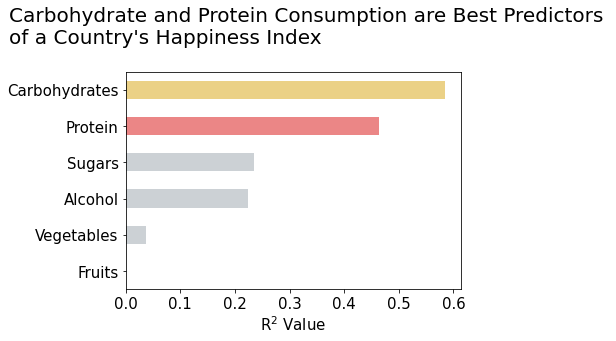

In [50]:
colors={'Sugars': '#CCD1D5', 'Carbohydrates': '#EBD186', 'Protein' : '#EB8686', 'Alcohol' : '#CCD1D5',
        'Vegetables': '#CCD1D5', 'Fruits' : '#CCD1D5'}
rsquared_bar = df_bar.plot.barh(x='Food Category', y='R^2',rot=0, legend=False, 
                                color=df_bar['Food Category'].replace(colors), fontsize=15)
rsquared_bar.set_xlabel("R$^2$ Value", fontsize=15)
rsquared_bar.set_ylabel("", fontsize=15)
rsquared_bar.set_title("Carbohydrate and Protein Consumption are Best Predictors \nof a Country's Happiness Index\n",
                      fontsize=20, horizontalalignment='left', x=-0.35)
rsquared_bar

The bar plot displays how the proportion of calorie consumption from carbohydrates and proteins are the strongest predictors of a country's happiness out of the analyzed food categories. While this graphic shows that these two food categories have strong relationships with a country's happiness index, it does not specify positive or negative correlation. We suspect that this is because the consumption of carbohydrates and protein on a national level is linked to a country's wealth level.

In [51]:
#add columns to rank countries by carbohydrate and protein consumption
df['carb_rank'] = df['Carbohydrates'].rank(method='min')
df['protein_rank'] = df['Protein'].rank(method='min')
df['gdp_rank'] = df['GDP'].rank(method='min')

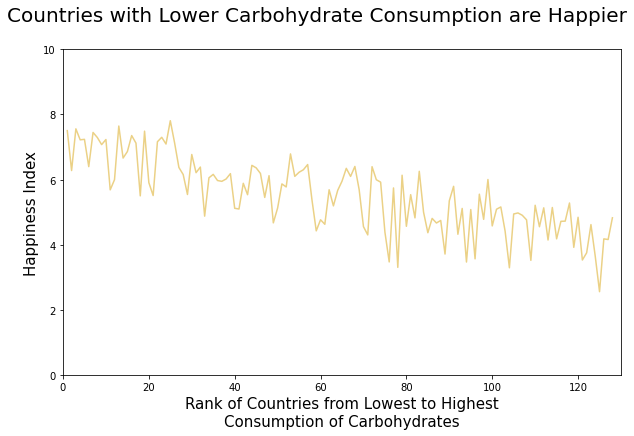

In [52]:
ax = plt.gca()

df = df.sort_values(by=['carb_rank'])
carb_rank_line = df.plot(kind='line',x='carb_rank',y='Happiness_Index', color='#EBD186', ax=ax, figsize=(10,6),
        legend=False)
carb_rank_line.set_xlabel("Rank of Countries from Lowest to Highest\nConsumption of Carbohydrates", fontsize=15)
carb_rank_line.set_ylabel("Happiness Index", fontsize=15)
carb_rank_line.set_title("Countries with Lower Carbohydrate Consumption are Happier\n",
                      fontsize=20, horizontalalignment='left', x=-0.1)
carb_rank_line.set_ylim(0,10)
carb_rank_line.set_xlim(0,130)

plt.show()

This line graph shows the negative correlation between the increased consumption of carbohydrates and a country's happiness index. Since carbohydrates are relatively more available and cheaper, the consumption of these foods would be beneficial towards wealth groups that are less fortunate (6). 

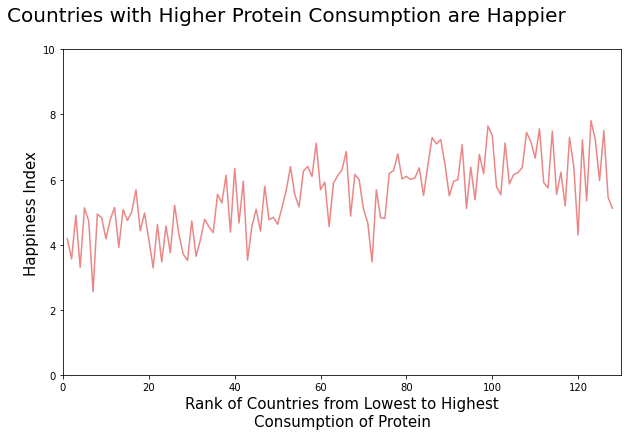

In [53]:
ax = plt.gca()

df = df.sort_values(by=['protein_rank'])
prot_rank_line = df.plot(kind='line',x='protein_rank',y='Happiness_Index', color='#EB8686', ax=ax, figsize=(10,6),
                         legend=False)
prot_rank_line.set_xlabel("Rank of Countries from Lowest to Highest\nConsumption of Protein", fontsize=15)
prot_rank_line.set_ylabel("Happiness Index", fontsize=15)
prot_rank_line.set_title("Countries with Higher Protein Consumption are Happier\n",
                      fontsize=20, horizontalalignment='left', x=-0.1)
prot_rank_line.set_ylim(0,10)
prot_rank_line.set_xlim(0,130)

plt.show()

This line graph shows the postivie correlation between the increased consumption of protein and a country's happiness index. The correlation between protein consumption and happiness index is slightly weaker than carbohydrates could be due to religious practices where meat consumption is prohibited (7).

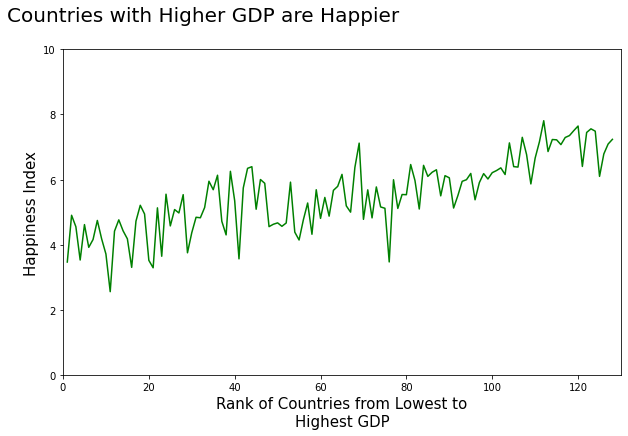

In [54]:
ax = plt.gca()

df = df.sort_values(by=['gdp_rank'])
prot_rank_line = df.plot(kind='line',x='gdp_rank',y='Happiness_Index', color='g', ax=ax, figsize=(10,6),
                         legend=False)
prot_rank_line.set_xlabel("Rank of Countries from Lowest to\nHighest GDP", fontsize=15)
prot_rank_line.set_ylabel("Happiness Index", fontsize=15)
prot_rank_line.set_title("Countries with Higher GDP are Happier\n",
                      fontsize=20, horizontalalignment='left', x=-0.1)
prot_rank_line.set_ylim(0,10)
prot_rank_line.set_xlim(0,130)

plt.show()

During multivariate regression analysis involving GDP, we found a high R-squared value and low p-value which indicates a strong positive relationship exists between GDP and happiness score. Because of protein consumption's relatively high p-value, GDP is likely a confounding variable in relation to happiness index. However, carbohydrates remain a strong predictor of happiness. Nonetheless, this analysis indicates that a country's economic status is likely related to the foods that are available to its citizens.

## Ethics and Privacy

Data unintentionally tracked includes race, ethnicity, and gender. Since data was collected by country, demographics for these groups are consequently also tracked. <br>

Possible stakeholders include national governing bodies and residents of each of the countries involved in the study as well as the World Happiness Report (WHR) organization. Poor happiness indices for countries may reflect poorly on national governments and contribute to civil unrest. Furthermore, since this model seeked to correlate food group consumption with happiness, it may influence international perception of countries, which in turn can affect international immigration patterns. Since data is sourced in part from the WHR organization, controversial results from this study may also affect WHR’s popularity and funding. <br>

Because analysis was conducted on a national level, the conclusions reached by this study should not be generalized to and are not representative of narrower scopes, such as at the provincial or state level. This model does not account for geo- or demographic heterogeneity within countries. <br>

The data used is available and accessible public information that was published online. <br>

Data measurements and conclusions drawn from this study could be used with malicious intent, as results tied to certain countries could be misconstrued to perpetuate racial, cultural, and ethnic stereotypes. Although we cannot prevent this possibility, we seek to be proactive in correcting incorrect or unreflective interpretations of our study that appear in the media.


## Conclusion and Discussion

While the World Happiness Report has indicated that an individual’s health can play a role in one’s happiness, the factors of healthiness that correlate to these effects are not well characterized (3). Here, we chose to narrow the focus of human health to dietary composition broken down by sources of calories, these groups being carbohydrates, protein, sugars, alcohol, vegetables, and fruits. We predicted that countries whose average diets source higher percentage calorie consumption from fruits and vegetables would receive higher happiness indices than those with lower consumption rates of fruits and vegetables, as medical professionals suggest these categories possess the highest proportion of available nutrients and superfoods (6). Using data from the 2020 World Happiness Report and the 2019 COVID-19 Healthy Diet dataset, we performed data analysis on the happiness and energy intake percentages of various food types for 128 countries. Descriptive analysis was first performed to gauge data distribution for happiness scores of all countries and caloric values for all food groups. Exploratory data analysis was then performed to determine the pairwise relationship between happiness and calorie intake from each food group, whereby linear regression models were generated to describe these relationships. <br>

Contrary to our expectations, we found that only percentage calorie consumption from carbohydrates and proteins were significantly correlated with happiness. Negative correlations between happiness and carbohydrate consumption indicated that countries with a lower carbohydrate intake tended to have higher happiness indices than countries with higher carbohydrate intakes. Positive correlations between happiness and protein consumption indicated that countries with higher protein consumption tended to have higher happiness indices. Surprisingly, the consumption of vegetables, fruits, and the other 2 food groups, although somewhat positively associated with happiness, ultimately had little to no correlation with happiness indices whatsoever. <br>

Noting that protein consumption tends to be higher and carbohydrate consumption tends to be lower in wealthier countries, we sought to determine whether or not a country’s GDP confounds the predictability of happiness level on the basis of protein and carbohydrate consumption (7). After applying multivariate linear regression using predictor variables GDP, protein consumption, and carbohydrate consumption, we determined that wealth level likely confounds protein consumption. On the other hand, the confounding effects of GDP on carbohydrate consumption are somewhat inconclusive, as both GDP and carbohydrate consumption had similarly low p-values. However, due to the low p-value of carbohydrate consumption (approximately 0.001), it is reasonable to assume that carbohydrate consumption remains a strong predictor of happiness. <br>

We acknowledge that because data were grouped by country, this may give rise to additional confounding factors. Characteristics of a country’s population, such as age distribution, climate and geography, culture, and religion, have strong influence on diet and therefore may confound diet’s relationship with happiness. However, carrying out extensive analysis on the relationships of factors related to culture, religion, and factors that may pertain to an individual’s identity is potentially irresponsible and dangerous (8). We seek to avoid generating models or conclusions that could be too easily abused to support ageism, colonialism, racism, and other forms of unethical labeling and stereotyping; we believe that models should not be generated to tie such qualities of an individual’s identity to happiness level. However, because of the potentiality of such confounding factors, we qualify that our conclusions are not absolute. <br>

The metrics of how the World Happiness Report calculates their happiness index changes annually as the organization shifts focus on different topics. In the 2020 report, there was an emphasis on the environment and its relationship to sustainability (9). Though our focus could be applied broadly to other years, this was a limitation that hindered our project from expanding to previous years. The addition of datasets from preceding years would’ve caused inconsistent results due to the fact that the World Happiness Report changes their main focus from year to year. Inclusion of all countries was another important limitation in our project as our number of operations lowered after we had merged both datasets. Likewise many countries often don’t report their data and would leave to many countries with missing data that must be left out in the analysis. <br>

We hope that the results of this study can spark closer scrutiny, especially from health professionals, on the effects of carbohydrate consumption on happiness. If the negative correlation between carbohydrate consumption and happiness can be supported both a statistical and medical standpoint, there may be sufficient evidence to support reducing the amount of calories individuals consume from carbohydrates. Since the growing importance of health and diet in our society often leads to dietary trends, we can possibly see a societal shift to individuals becoming more conscious of daily carbohydrate intake. Were such trends to go into effect on a larger scale, this may have some long-term downstream effects on the economies of countries with high grain production and exports. <br>


## References

1. [World Happiness Report Website](https://worldhappiness.report/)
2. [What is MyPlate](https://www.choosemyplate.gov/WhatIsMyPlate)
3. [World Happiness Report 2020](https://happiness-report.s3.amazonaws.com/2020/WHR20.pdf)
4. [Why Healthy Eating Matters](http://www.foodincare.org.uk/eating-well/why-healthy-eating-matters)
5. [Common Superfoods](https://www.medicalnewstoday.com/articles/303079#common_superfoods)
6. [University of Maryland](https://extension.umd.edu/poultry/small-flock-production/carbohydrates-inexpensive-sources-energy)
7. [The Royal Society Publishing](https://royalsocietypublishing.org/doi/10.1098/rstb.2010.0149)
8. [National Center for Biotechnology Information](http://www.ncbi.nlm.nih.gov/books/NBK206912/)
9. [World Happiness Report Website](https://worldhappiness.report/ed/2020/environments-for-happiness-an-overview/)

## Team Contributions

Each team member contributed to the following sections:

- Mason: Setup, Cleaning, and Wrangling of the data, Descriptive and EDA, Conclusion and Discussion
- Helen: Research Question, Background, Hypothesis, Descriptive Analysis, EDA, and Data Visualizations
- James: Overview, Descriptive Analysis, EDA, Data Visualizations, Ethics and Privacy, Conclusion and Discussion